# Grad-CAM++

This notebook implements the Grad-CAM++ algorithm, used in interpretability of Convolutional Networks.

Reference: https://arxiv.org/pdf/1710.11063.pdf

In [18]:
LAST_CONV_LAYER = 'top_activation'

NUM_SAMPLES = 50
NOISE = .2

## Setup

In [2]:
from google.colab import drive
drive.mount('/content/drive')

! cp -r '/content/drive/MyDrive/Colab Notebooks/cs-no/6.grads/config' .

Mounted at /content/drive


In [3]:
import tensorflow as tf

from config import config, data, model, utils
from config.utils import to_image, normalize, standardize

utils.setup_clean_image_plotting()

In [9]:
images = data.load_images()
x = model.preprocess(images)

In [8]:
nn = model.build()

logits = nn(x, training=False)
preds = tf.argmax(logits, axis=-1)
probs = tf.nn.softmax(logits)
decoded = model.decode(probs.numpy(), top=5)

40960/35363 [==================================] - 0s 0us/step


In [11]:
utils.plot(to_image(images),
           titles=[f'{n}\n{e[0][1]} {e[0][2]:.0%}'
                   for n, e in zip(data.class_names, decoded)],
           rows=4)

Output hidden; open in https://colab.research.google.com to view.

## Grad-CAM++

In [19]:
l = nn.get_layer(LAST_CONV_LAYER)
model_s = tf.keras.Model(nn.inputs, nn.outputs + [l.output])

In [29]:
def activation_loss(y, units):
    return tf.gather(y, units, axis=1, batch_dims=1)

@tf.function
def gradcampp(inputs, units):
    with tf.GradientTape(watch_accessed_variables=False) as tape:
        tape.watch(inputs)
        y, z = model_s(inputs, training=False)
        loss = activation_loss(y, units)

    dydx, grads = tape.gradient(loss, [inputs, z])

    # Computing a_kc.
    dy = tf.reshape(tf.exp(loss), (-1, 1, 1, 1)) * grads
    d2 = grads**2
    d3 = grads**3

    num = d2
    aab = tf.reduce_sum(z, axis=(1, 2), keepdims=True)
    dem = 2.*d2 + aab * d3
    dem = tf.where(dem != 0, dem, tf.ones_like(dem)) + 1e-7
    akc = num / dem

    weights = tf.reduce_mean(akc*tf.nn.relu(dy), axis=(1, 2), keepdims=True)
    maps = tf.reduce_sum(z*weights, axis=-1, keepdims=True)

    # We are not concerned with pixels that negatively contribute
    # to its classification, only pixels that belong to that class.
    maps = tf.nn.relu(maps)
    maps = standardize(maps)

    maps = tf.map_fn(lambda i: tf.image.resize(i, config.data.image_size), maps)

    return loss, dydx, maps

In [30]:
loss, grads, maps = gradcampp(x, preds)

In [31]:
# Absolute gradients weighted CAM
gs = tf.abs(grads)
gs = standardize(gs)

gm = tf.reduce_sum(gs * maps, axis=-1, keepdims=True)
gm = normalize(gm)

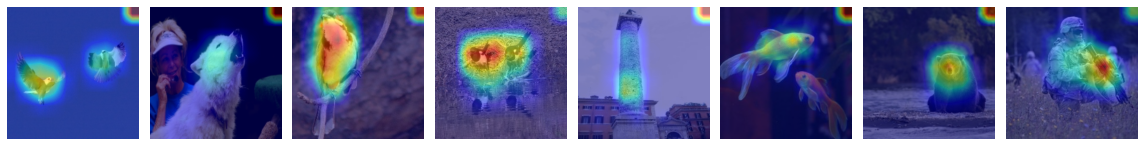

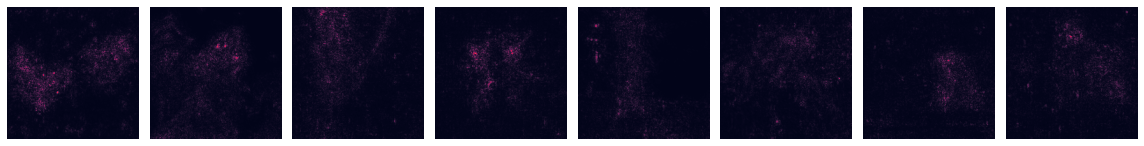

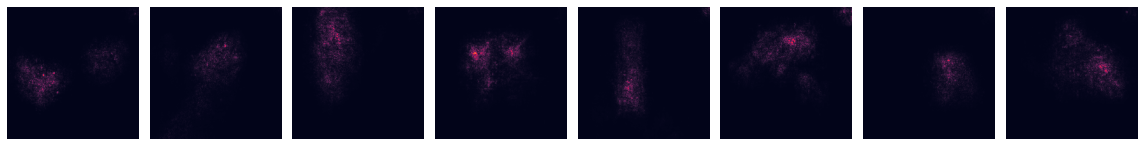

In [32]:
#@title

utils.plot_heatmaps(to_image(images[:8]), maps[:8, ..., 0].numpy())
utils.plot(gs[:8, ..., 0].numpy())
utils.plot(gm[:8, ..., 0].numpy())

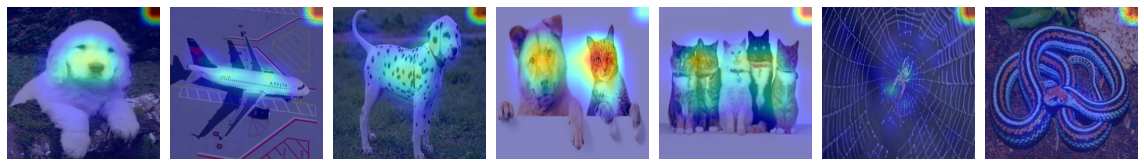

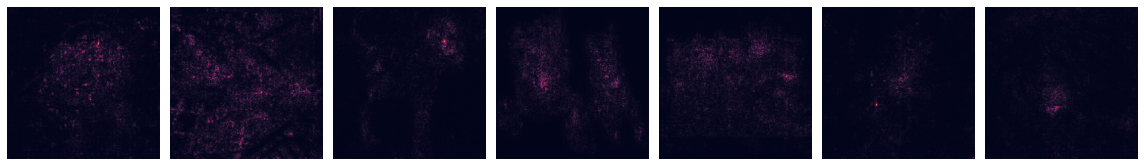

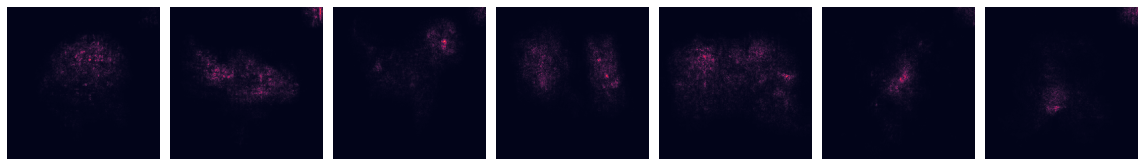

In [33]:
#@title

utils.plot_heatmaps(to_image(images[8:]), maps[8:, ..., 0].numpy())
utils.plot(gs[8:, ..., 0].numpy())
utils.plot(gm[8:, ..., 0].numpy())